In [1]:
import numpy as np
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from derivations_densities import gen_tau, gen_beta, compdS

In [23]:
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)#[0:B_zeta.shape[0]]
n = B_zeta.shape[0]
p = B_zeta.shape[1]

BoB = B_zeta**2
tau_start = 0.001
beta = np.zeros(p)
theta=2.5
J = [5000,10000]
tBB = B_zeta.T.dot(B_zeta)

In [3]:
# initialize Lambda
betaBt = beta.dot(B_zeta.T)

In [4]:
W = np.array([B_zeta[i,:].dot(B_zeta[i,:]) for i in range(0, n)])
S2, dS2, ddS2, S = compdS(tau_start, W)

In [5]:
tau_old = tau_start
all_taus = []
tau_acc = []
all_betas = []
for i in [0,1]:
    if i == 0:
        print('warm-up phase')
    elif i == 1:
        print('sampling phase')
    for j in tqdm(range(0, J[i])):
        
        # sample beta
        betanew = gen_beta(z,np.log(tau_old),B_zeta,tBB,S)
        
        all_betas.append(betanew)
        betaBt = B_zeta.dot(betanew)
        tau_new, decision_criterion , S2_new, dS2_new, ddS2_new, S_new = gen_tau(tau_old, W, B_zeta, z, betanew, theta, betaBt)
        
        if np.log(np.random.uniform(0,1,1)) <= decision_criterion:
            tau_old, S2, dS2, ddS2, S = tau_new.copy(), S2_new.copy(), dS2_new.copy(), ddS2_new.copy(), S_new.copy()
            all_taus.append(tau_old)
            tau_acc.append(1)
        else:
            all_taus.append(tau_old)
            tau_acc.append(0)
        if j%1000 == 0 & i == 1:
            print('acceptance rate for last 1000 iterates:' + str(np.mean(tau_acc[-1000:])))           

  0%|          | 1/5000 [00:00<11:28,  7.26it/s]

warm-up phase


  0%|          | 1/10000 [00:00<29:19,  5.68it/s]

sampling phase


100%|██████████| 10000/10000 [30:54<00:00,  5.39it/s]


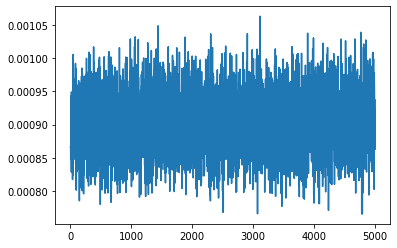

In [7]:
plt.plot(all_taus[J[1]:])

In [9]:
np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/taus.npy', np.array(all_taus[J[1]:]))
np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/betas.npy', np.array(all_betas[J[1]:]))

In [10]:
print('\nAcceptance rate for tau: ' + str(np.mean(tau_acc[J[0]:])))


Acceptance rate for tau: 0.8373


In [16]:
# mean betas
beta_mcmc = np.mean(np.array(all_betas[J[1]:]), axis = 0)

In [20]:
y_pred_mcmc = B_zeta.dot(beta_mcmc)

In [21]:
np.mean(abs(y_pred - z))

0.4100223290917766

In [28]:
y_pred_dnn = B_zeta.dot(beta)
np.mean(abs(y_pred_dnn - z))

0.3883803309803404

In [25]:
beta = np.genfromtxt(beta_path, delimiter=',')